In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
df_income = pd.read_csv("adult.csv")

In [3]:
df_income["income"] = df_income["income"].apply(lambda x: 1 if ">50K" in x else 0)

In [4]:
df_income = df_income.drop(columns=["fnlwgt"])

**Aufsplitten in df_income_train und df_income_test (Training und Test Daten)**

In [5]:
df_income_train, df_income_test = train_test_split(
    df_income,
    test_size=0.2,
    random_state=42
    )

**Aufspliten in input und output/target der Trainings-Daten**



In [6]:
# x_train_income_raw -> Input fürs Modell - "income"-Spalte rausgenommen - raw, weil noch kein preprocessing angewandt
x_train_income_raw = df_income_train.drop("income", axis=1)

# y_train_income -> echte bzw. ideale Lösung (Kontrolle für die vorhersage des Modells) - nur "income"-Spalte
y_train_income = df_income_train["income"]

**Das gleiche nochmal nur für die Test-Daten** (Input/Target der Test-Daten)

In [7]:
x_test_income_raw = df_income_test.drop("income", axis=1)
y_test_income = df_income_test["income"]

---

OneHotEncoder

In [8]:
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

StandardScaler

In [9]:
default_num_pipeline = make_pipeline(StandardScaler())

**diesen beiden nun als preprocessing Regeln einstellen:**

In [10]:
preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)), # alle Spalten, die type: "object" haben (aka. String/Text -> alles was keine Zahl ist) wird hier der OneHotEncoder zugewiesen
    ],
    remainder=default_num_pipeline, sparse_threshold=0) # alle restlichen ("Zahlen") Spalten, bekommen hier den StadardScaler zugewiesen


---

**Preprocessing(-pipeline) anwenden**

In [11]:
x_train_income = preprocessing.fit_transform(x_train_income_raw)
x_test_income = preprocessing.transform(x_test_income_raw)

---

**Training des Lineare Regression Models**

In [12]:
model_lr = LogisticRegression(
    max_iter=100,
    )
model_lr.fit(x_train_income, y_train_income)

LogisticRegression()

---

**Vorhersagen auf den Trainingsdaten mit dem trainierten Modell**

In [13]:
# Sicherstellen, dass y binär (in Integer) ist
y_train_income = y_train_income.astype(int)
y_test_income = y_test_income.astype(int)

In [14]:
# Vorhersage auf Trainingsdaten
y_pred_train = model_lr.predict(x_train_income)

# Accuracy
acc_train = accuracy_score(y_train_income, y_pred_train)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_train_income, y_pred_train, labels=[0,1]).ravel()

# Prozentwerte
false_positive_rate_train = fp / (fp + tn) * 100
false_negative_rate_train = fn / (fn + tp) * 100

print(f"Train Accuracy: {acc_train*100:.2f}%")
print(f"Train False Positives: {false_positive_rate_train:.2f}% ({fp} Stück)")
print(f"Train False Negatives: {false_negative_rate_train:.2f}% ({fn} Stück)")


Train Accuracy: 85.20%
Train False Positives: 6.83% (2028 Stück)
Train False Negatives: 39.94% (3753 Stück)


In [15]:
# Vorhersage auf Testdaten
y_pred_test = model_lr.predict(x_test_income) # Für jede Testzeile sagt das Modell voraus, ob das Einkommen 0 (≤50K) oder 1 (>50K) ist.

# Accuracy
acc = accuracy_score(y_test_income, y_pred_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test_income, y_pred_test, labels=[0,1]).ravel()

# Prozentwerte
false_positive_rate = fp / (fp + tn) * 100  # Anteil fälschlich als >50K erkannter Fälle
false_negative_rate = fn / (fn + tp) * 100  # Anteil fälschlich als ≤50K erkannter Fälle

print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test False Positives: {false_positive_rate:.2f}% ({fp} Stück)")
print(f"Test False Negatives: {false_negative_rate:.2f}% ({fn} Stück)")

Test Accuracy: 85.56%
Test False Positives: 6.78% (507 Stück)
Test False Negatives: 39.48% (904 Stück)


---

Modellbewertung:

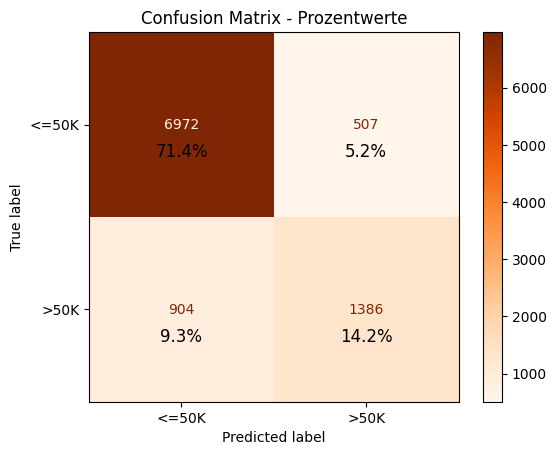

In [16]:
cm = confusion_matrix(y_test_income, y_pred_test, labels=[0,1])
cm_percent = cm / cm.sum() * 100  # Prozentwerte bezogen auf die gesamte Matrix

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap=plt.cm.Oranges, ax=ax, values_format="")  # Standardzahlen unterdrücken

# Nur Prozentzahlen hinzufügen, etwas tiefer in der Zelle, in weiß
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i + 0.15, f"{cm_percent[i,j]:.1f}%",
                ha='center', va='center', color='black', fontsize=12)


plt.title("Confusion Matrix - Prozentwerte")
plt.show()


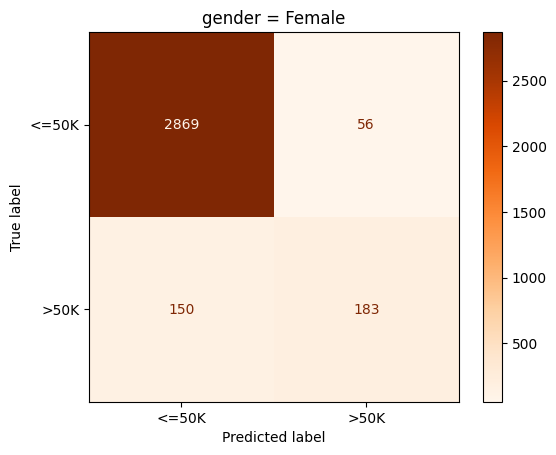

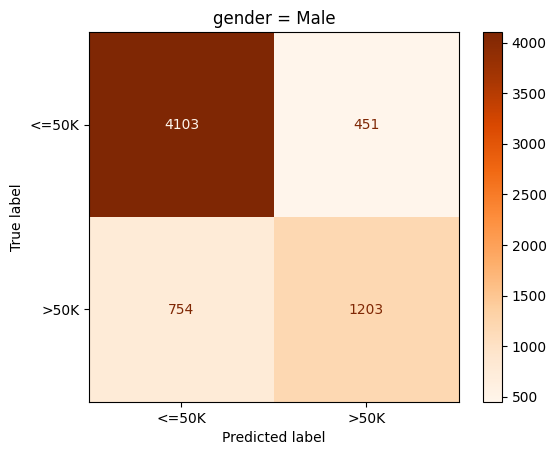

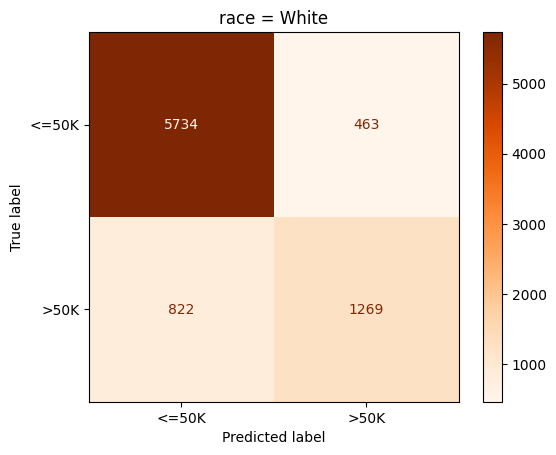

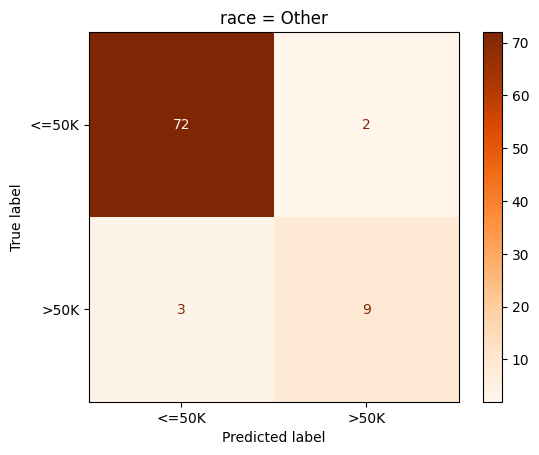

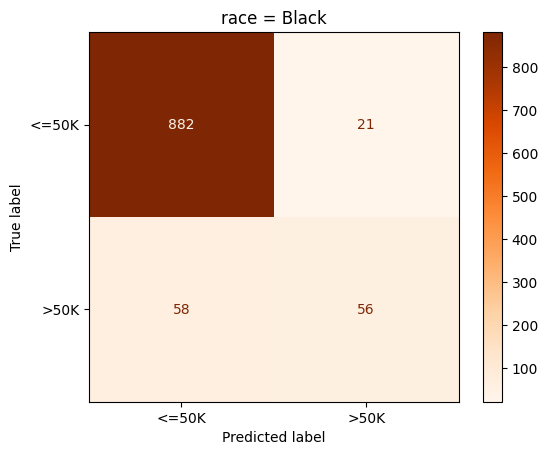

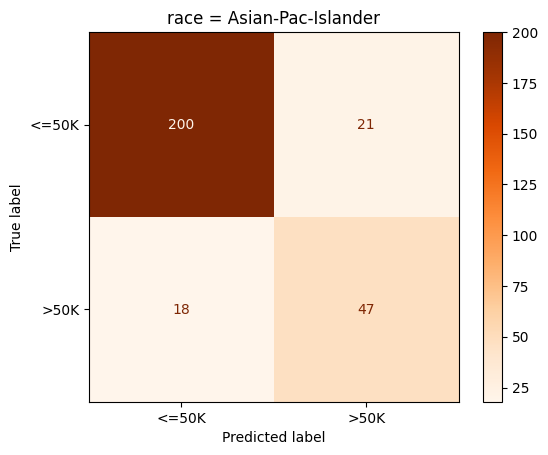

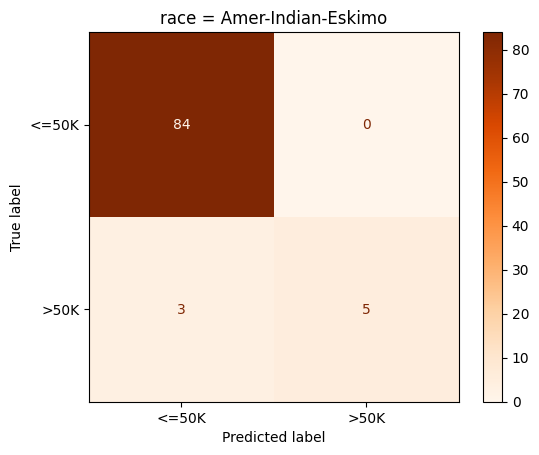

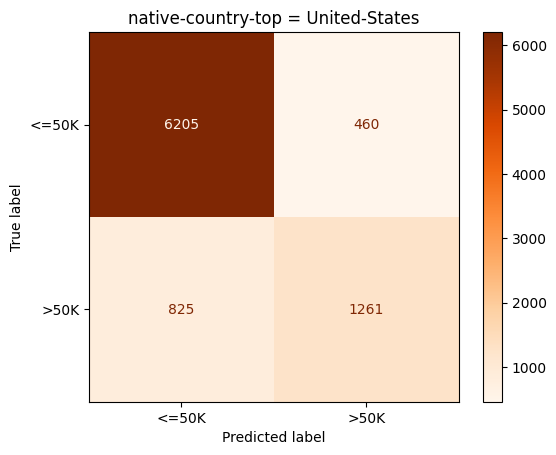

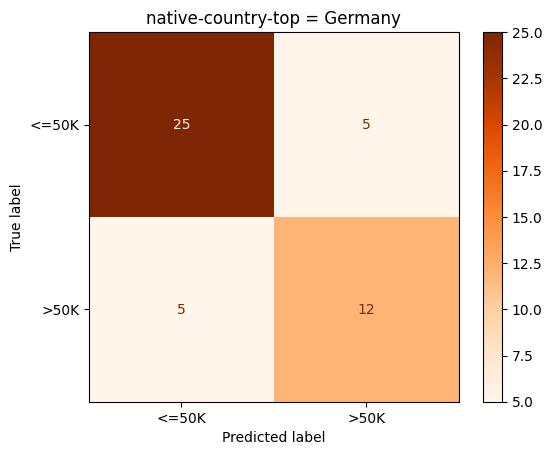

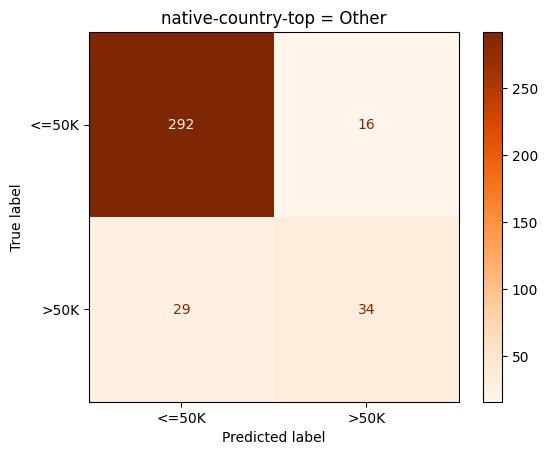

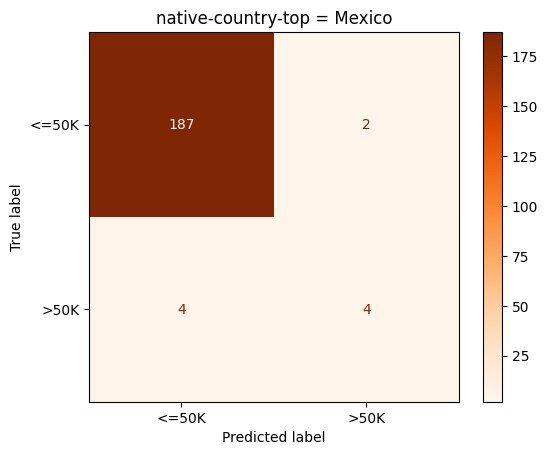

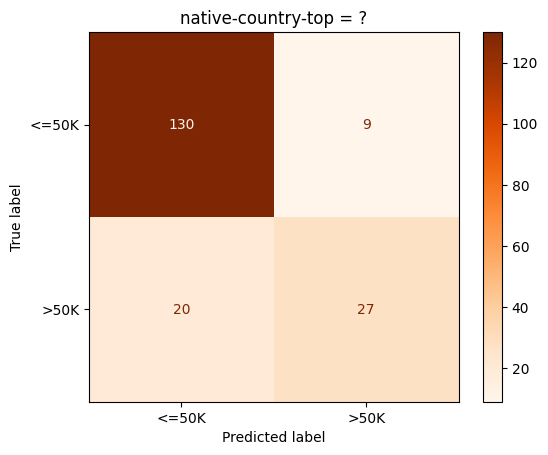

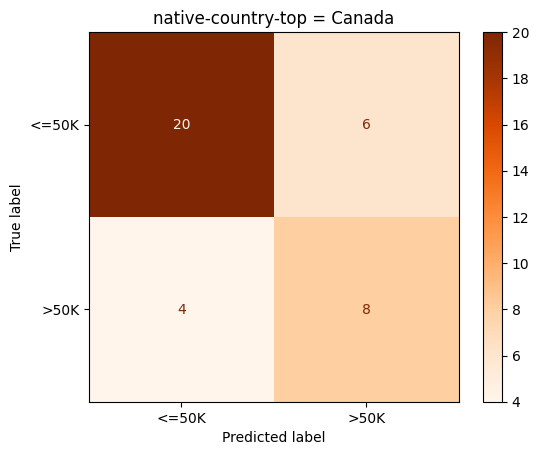

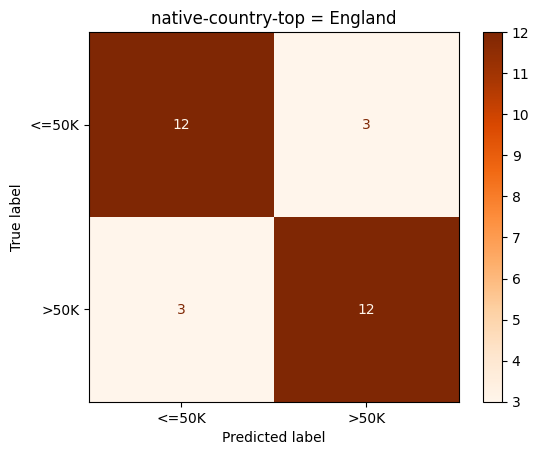

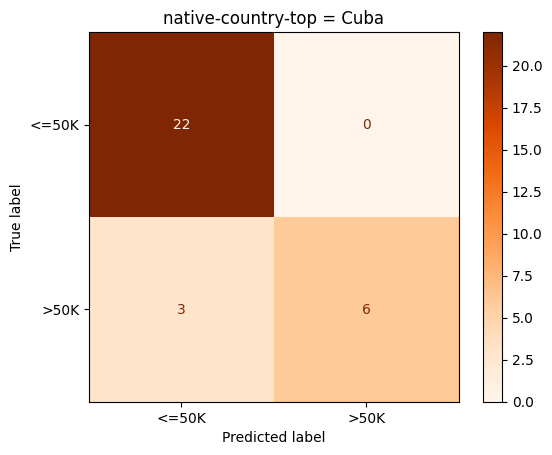

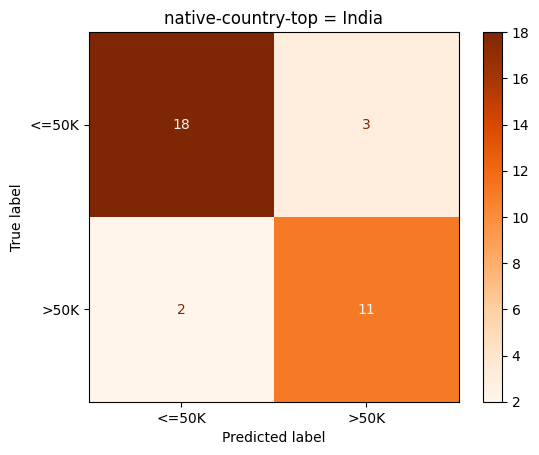

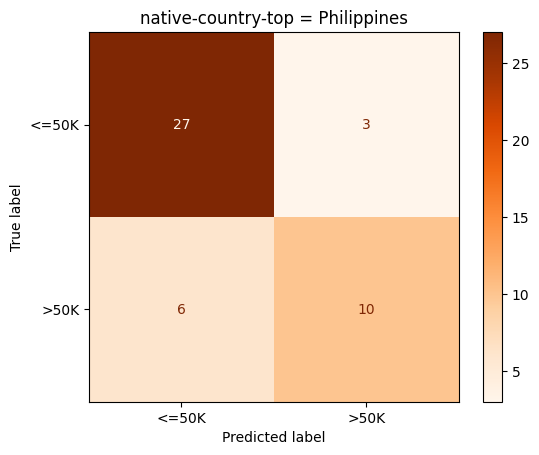

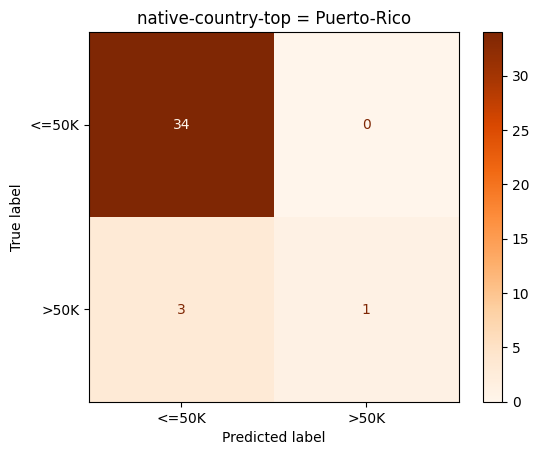

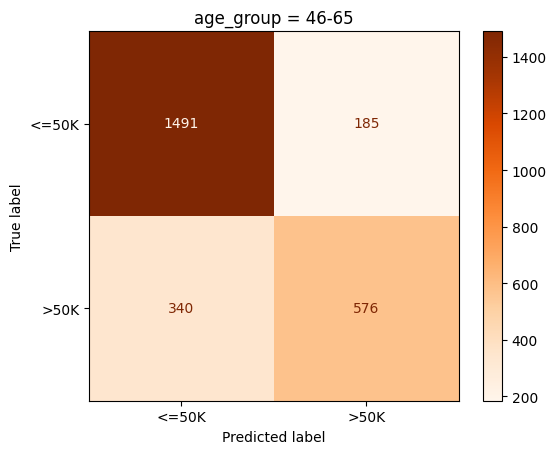

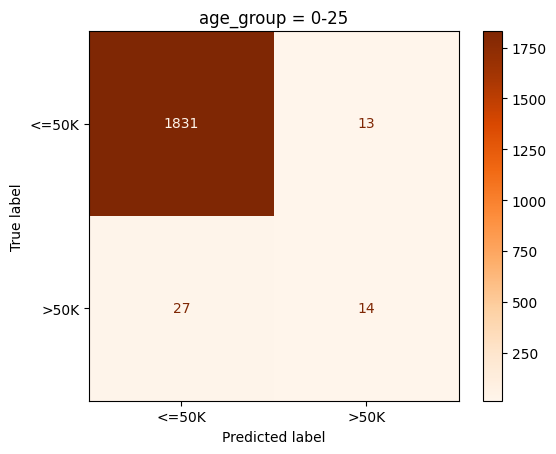

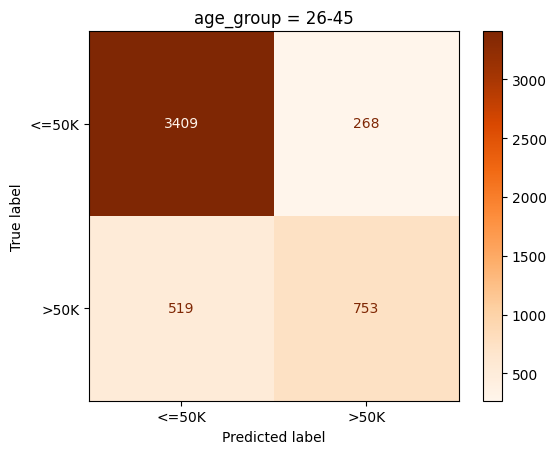

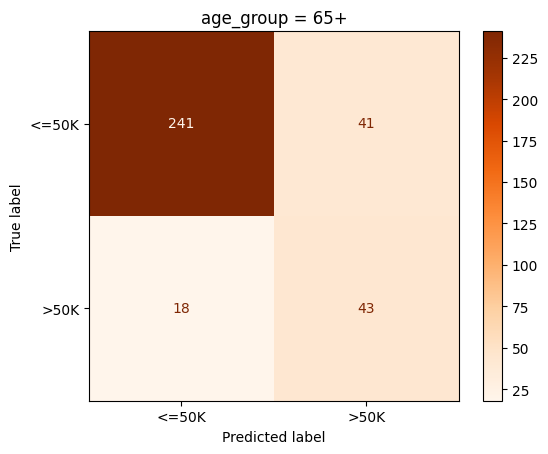

In [17]:
# Altersgruppen definieren
age_bins = pd.cut(df_income_test["age"], bins=[0,25,45,65,200], labels=["0-25","26-45","46-65","65+"])
df_income_test["age_group"] = age_bins

# Nur die Top 10 Länder betrachten
top_countries = df_income_test["native-country"].value_counts().head(10).index
df_income_test["native-country-top"] = df_income_test["native-country"].apply(lambda x: x if x in top_countries else "Other")

# untersuchende Features
features = ["gender", "race", "native-country-top", "age_group"]

for feat in features:
    for val in df_income_test[feat].unique():
        mask = df_income_test[feat] == val
        cm = confusion_matrix(
            y_test_income[mask],
            y_pred_test[mask],
            labels=[0,1]
        )
        disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
        disp.plot(cmap=plt.cm.Oranges)
        plt.title(f"{feat} = {val}")
        plt.show()

In [18]:
married_values = [
    "Married-civ-spouse",
    "Married-spouse-absent",
    "Married-AF-spouse"
]


# Sicherheitskopie
df_income_test = df_income_test.copy()

# married_group hinzufügen zur Analyse (da in das nur in Bias mitigierten Modell erstellt wurde)
df_income_test["married_group"] = df_income_test["marital-status"].apply(
    lambda x: "Married" if x in married_values else "Unmarried"
)

# Altersgruppen hinzufügen
df_income_test["age_group"] = pd.cut(
    df_income_test["age"],
    bins=[0, 25, 45, 65, 200],
    labels=["0-25", "26-45", "46-65", "65+"]
)

# Vorhersagen in Pandas Series umwandeln, falls NumPy-Arrays
y_test_income = pd.Series(y_test_income, index=df_income_test.index)
y_pred_test = pd.Series(y_pred_test, index=df_income_test.index)

# Features, die untersucht werden sollen
features_to_check = ["married_group", "gender", "race", "native-country", "age_group"]

# Ergebnisse speichern
results = []

for feat in features_to_check:
    print(f"\nAnalyse für Feature: {feat}")

    for subgroup in df_income_test[feat].dropna().unique():
        mask = df_income_test[feat] == subgroup

        # Reale Werte + Vorhersagen für diese Gruppe
        y_true_sub = y_test_income.loc[mask]
        y_pred_sub = y_pred_test.loc[mask]

        # kleine Gruppen überspringen
        if len(y_true_sub) < 20:
            continue

        # Confusion-Matrix sicher entpacken
        cm = confusion_matrix(y_true_sub, y_pred_sub, labels=[0,1])
        tn, fp, fn, tp = (cm.flatten().tolist() + [0, 0, 0, 0])[:4]

        # Schutz vor Division durch 0
        fp_rate = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
        fn_rate = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0

        acc = accuracy_score(y_true_sub, y_pred_sub) * 100

        results.append({
            "Feature": feat,
            "Subgruppe": subgroup,
            "Samples": len(y_true_sub),
            "Accuracy (%)": round(acc, 2),
            "False Positives (%)": round(fp_rate, 2),
            "False Negatives (%)": round(fn_rate, 2)
        })

# Ergebnisse in DataFrame
results_df = pd.DataFrame(results)

# Schön sortiert ausgeben
pd.set_option('display.max_rows', None)
display(results_df.sort_values(["Feature", "Accuracy (%)"], ascending=[True, False]))


Analyse für Feature: married_group

Analyse für Feature: gender

Analyse für Feature: race

Analyse für Feature: native-country

Analyse für Feature: age_group


,Feature,Subgruppe,Samples,Accuracy (%),False Positives (%),False Negatives (%)
26,age_group,0-25,1885,97.88,0.70,65.85
27,age_group,26-45,4949,84.10,7.29,40.80
28,age_group,65+,343,82.80,14.54,29.51
25,age_group,46-65,2592,79.75,11.04,37.12
2,gender,Female,3258,93.68,1.91,45.05
3,gender,Male,6511,81.49,9.90,38.53
0,married_group,Unmarried,5228,95.50,0.39,66.87
1,married_group,Married,4541,74.10,18.96,34.98
11,native-country,Dominican-Republic,27,100.00,0.00,0.00
12,native-country,Mexico,197,96.95,1.06,50.00


trainierte-Modell als Gleichung bzw. gewichtung ansehen

In [19]:
# Feature-Namen aus Preprocessing
feature_names = preprocessing.get_feature_names_out()

# Gewichte
for name, coef in zip(feature_names, model_lr.coef_[0]):
    print(f"{name}: {coef:.4f}")

# Bias ausgeben
print("Intercept (Bias):", model_lr.intercept_[0])

print()
print()

# Und jetzt als wirkliche "Gleichung"
eq = " + ".join([f"{coef:.4f}*{name}" for name, coef in zip(feature_names, model_lr.coef_[0])])
eq = f"logit(p) = {eq} + {model_lr.intercept_[0]:.4f}"
print(eq)

cat__workclass_?: -0.3455
cat__workclass_Federal-gov: 0.5151
cat__workclass_Local-gov: -0.1925
cat__workclass_Never-worked: -0.0648
cat__workclass_Private: 0.0100
cat__workclass_Self-emp-inc: 0.1879
cat__workclass_Self-emp-not-inc: -0.5366
cat__workclass_State-gov: -0.3580
cat__workclass_Without-pay: -0.3691
cat__education_10th: -0.1544
cat__education_11th: -0.2750
cat__education_12th: -0.2210
cat__education_1st-4th: -0.0104
cat__education_5th-6th: 0.3261
cat__education_7th-8th: -0.1755
cat__education_9th: -0.0686
cat__education_Assoc-acdm: -0.4003
cat__education_Assoc-voc: -0.1590
cat__education_Bachelors: -0.0580
cat__education_Doctorate: 0.0498
cat__education_HS-grad: -0.0835
cat__education_Masters: -0.0010
cat__education_Preschool: -0.0758
cat__education_Prof-school: 0.1358
cat__education_Some-college: 0.0176
cat__marital-status_Divorced: -0.7851
cat__marital-status_Married-AF-spouse: 1.3552
cat__marital-status_Married-civ-spouse: 1.5797
cat__marital-status_Married-spouse-absent: -

In [20]:
# DataFrame mit Feature-Namen und Gewichten
weights_df = pd.DataFrame({
    "Feature": feature_names,
    "Weight": model_lr.coef_[0],
})

# Absoluter Betrag = Stärke des Einflusses (egal ob positiv oder negativ)
weights_df["Abs Weight"] = np.abs(weights_df["Weight"])

# Nach Einfluss sortieren
weights_df = weights_df.sort_values("Abs Weight", ascending=False)

# Top 10 wichtigsten Features
print("Top 10 wichtigste Features:")
print(weights_df.head(10))

# (Optional) Kleinste Gewichte (also unwichtige Features)
print("\nAm wenigsten einflussreiche Features:")
print(weights_df.tail(10))

Top 10 wichtigste Features:
                                    Feature    Weight  Abs Weight
104                 remainder__capital-gain  2.322957    2.322957
27   cat__marital-status_Married-civ-spouse  1.579665    1.579665
64             cat__native-country_Columbia -1.380965    1.380965
26    cat__marital-status_Married-AF-spouse  1.355228    1.355228
41          cat__occupation_Priv-house-serv -1.214431    1.214431
29        cat__marital-status_Never-married -1.206533    1.206533
95                cat__native-country_South -1.071173    1.071173
50              cat__relationship_Own-child -0.918755    0.918755
58                       cat__gender_Female -0.913126    0.913126
37          cat__occupation_Farming-fishing -0.906115    0.906115

Am wenigsten einflussreiche Features:
                                   Feature    Weight  Abs Weight
77                cat__native-country_Hong -0.035576    0.035576
51             cat__relationship_Unmarried  0.033336    0.033336
33          